In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy import ndimage as ndi
import skimage
from skimage.feature import peak_local_max
import time

In [35]:
newparams = {'axes.labelsize': 26, 'axes.linewidth': 1, 'savefig.dpi': 300, 
             'lines.linewidth': 2, 'figure.figsize': (8, 6),
             'figure.subplot.wspace': 0.4,
             'ytick.labelsize': 24, 'xtick.labelsize': 24,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 26, 'legend.frameon': True, 
             'legend.handlelength': 2}
plt.rcParams.update(newparams)

#savedir="/Users/yli/Desktop/research/Writing/publication/VSF/ApJ/Submit/"
savedir="/Users/yli/Desktop/research/Projects/2019_VSF/new_Grant/"
#savedir="Grant_experiments/"

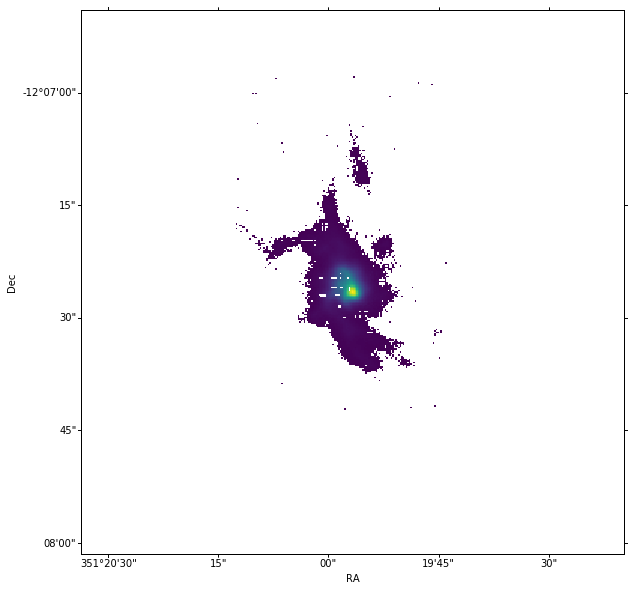

In [36]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename


#BH_RA=23:25:19.735 
#BH_Dec=-12:07:27.153
                
filename = get_pkg_data_filename('yuan/Ha_flux_map.fits')
plt.clf()
#fig, ax = plt.subplots(figsize = (10,10)) 
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize = (10,10))
fig.add_subplot(111, projection=wcs)
plt.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
#plt.plot(BH_RA,BH_Dec,marker="o")
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

After the watershed algorithm it will have clumps which we need to extract data from. skimage.measure.regionprops takes those clumps and outputs all the necessary data we need such as masks for each clump. We then simply sum up the electrons of each of the clump pixels and plot all of them on a histogram.

In [37]:
import astropy as astropy
import astropy.wcs as my_wcs
my_wcs.utils.proj_plane_pixel_scales(wcs)

array([5.55555556e-05, 5.55555556e-05])

In [38]:
##BH_RA=23:25:19.735 
#BH_Dec=-12:07:27.153
from astropy import units as u
print(wcs)
from astropy.coordinates import SkyCoord
c = SkyCoord('23:25:19.735 -12:07:27.153', unit=(u.hourangle, u.deg))
print(c,"CRVAL must be the center!!")

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 351.332083  -12.12389  
CRPIX : 186.994787080223  177.62417769387  
CD1_1 CD1_2  : -5.55555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555556e-05  
NAXIS : 361  362
<SkyCoord (ICRS): (ra, dec) in deg
    (351.33222917, -12.12420917)> CRVAL must be the center!!


In [39]:
351.33208300000001+186.99478708022301*5.5555555555555599e-05
0.2/3600

5.555555555555556e-05

In [40]:
BH_x_shift=(351.33222917-351.33208300000001)/5.5555555555555599e-05
BH_y_shift=(-12.123889999999999+12.12420917)/5.5555555555555599e-05
print(BH_x_shift,BH_y_shift)
center=(361./2-BH_x_shift,362./2-BH_y_shift)
print(center)

2.631059999885108 5.745060000016617
(177.8689400001149, 175.25493999998338)


In [41]:
flux = fits.open('yuan/Ha_flux_map.fits')
#flux = fits.open('yuan/Ha_flux_map.fits')


print(flux.info)
flux_data = flux[0].data
flux.close()
#velo = fits.open('yuan/Ha_vel_map.fits') #this is the old one

velo=fits.open('a2597_vel.fits')
print(velo.info)
velo_data = velo[0].data
velo.close()
#dir(velo[0])

#error=fits.open("yuan/Ha_vel_err_map.fits")
error=fits.open("/Users/yli/Downloads/repaperdraftonclusterturbulenceskypemeeting/Ha_vel_err_map.fits")


error_data = error[0].data
#error.info()
error.close()
#dir(velo[0])


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x123bd9b70>]>
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x123e944e0>]>


In [42]:
res=0.3
r10=8./res # it makes more sense to use 8kpc here
max_error=20

xvalues = np.arange(0,len(velo_data[0,:]));
yvalues = np.arange(0,len(velo_data[:,0]));
xx, yy = np.meshgrid(xvalues, yvalues)
print(xx.shape,velo_data.shape)

finite_mask = np.where(np.isfinite(velo_data))
velo_finite = velo_data[finite_mask]

#print(np.min(velo_finite),np.max(velo_finite))
print("totla number of points with good velocity:", velo_finite.shape)


#good_v=(velo_data<1000)&(velo_data>-2000)&(error_data<max_error)
good_v=(velo_data<1000)&(velo_data>-500)&(error_data<max_error)#&~((xx>190)&(xx<220)&(yy>190)&(yy<220))


print("good_v",good_v.shape)

print("totla number of points used:", velo_data[good_v].shape)

(362, 361) (362, 361)
totla number of points with good velocity: (4999,)
good_v (362, 361)
totla number of points used: (4023,)


/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


In [43]:

velo_plot = np.ma.masked_array(velo_data, mask=~good_v)

#add experiment
#flat=(xx<180)&(yy<180)
#velo_plot[flat]=0.001
#velo_data[flat]=velo_data[flat]*0.1




print(center)
(Cx,Cy)=center
xmin=100
xmax=290
ymin=90
ymax=250
print(np.min(velo_plot),np.max(velo_plot))

(177.8689400001149, 175.25493999998338)
-160.3046875 395.759765625


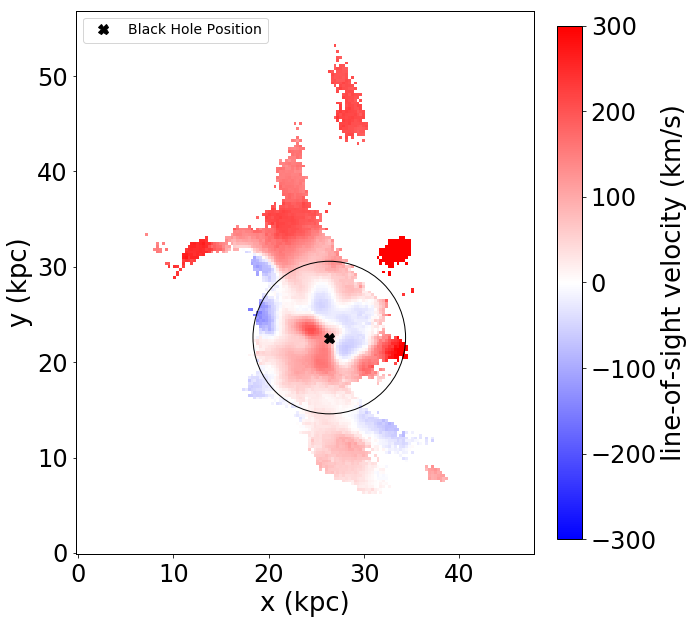

In [44]:
plt.clf()
#f = plt.figure(figsize = (10,10))
fig, ax = plt.subplots(figsize = (10,10)) 

plt.plot(Cx-ymin,Cy-xmin,marker="X",color="k",markersize=10,linestyle="None",label="Black Hole Position")
circle1= plt.Circle((Cx-ymin, Cy-xmin), radius= r10, color='k', fill=False)
circle2= plt.Circle((Cx-ymin, Cy-xmin), radius= r10*2, color='k', fill=False)
ax.add_artist(circle1)
#ax.add_artist(circle2)
#plt.imshow(error_data[xmin:xmax, ymin:ymax],vmin=0, vmax=30) #Marie-Lou
plt.imshow(velo_plot[xmin:xmax, ymin:ymax],vmin=-300, vmax=300,cmap="bwr") #Marie-Lou
#plt.imshow(velo_plot,vmin=-500, vmax=500,cmap="rainbow")
#y_locs=np.array([20,100,200])
y_labels=np.arange(0,60,10)
y_locs=y_labels/res
x_labels=np.arange(0,50,10)
x_locs=x_labels/res
plt.xticks(x_locs, x_labels)
plt.yticks(y_locs, y_labels)
plt.xlabel("x (kpc)")
plt.ylabel("y (kpc)")
#plt.imshow(velo_data[80:480, 500:750], norm = LogNorm()) #Marie-Lou
#plt.imshow(NGC_Data[800:1250, 200:1100], norm = LogNorm())
plt.gca().invert_yaxis()
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label("line-of-sight velocity (km/s)")
plt.legend(loc="upper left",prop={'size': 14})
plt.savefig("Grant_Halpha_velo_map.png")
plt.show()

/Users/yli/source/yt-conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


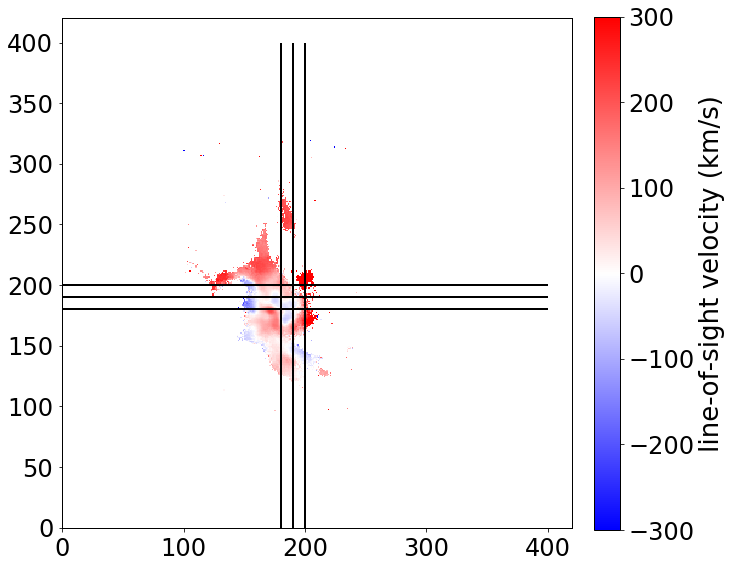

In [45]:
plt.clf()
#f = plt.figure(figsize = (10,10))
fig, ax = plt.subplots(figsize = (10,10)) 

plt.imshow(velo_data,vmin=-300, vmax=300,cmap="bwr") #Marie-Lou
plt.hlines([180,190,200],0,400,colors="k")
plt.vlines([180,190,200],0,400,colors="k")
#plt.imshow(velo_data[80:480, 500:750], norm = LogNorm()) #Marie-Lou
#plt.imshow(NGC_Data[800:1250, 200:1100], norm = LogNorm())
plt.gca().invert_yaxis()
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label("line-of-sight velocity (km/s)")
plt.legend(loc="upper left",prop={'size': 14})
plt.show()

/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


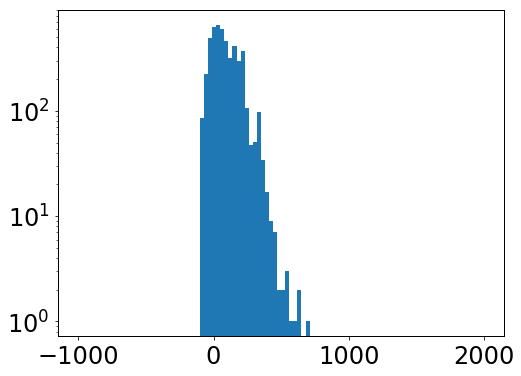

In [46]:
plt.hist(velo_plot[velo_plot>-100],bins=100,range=(-1000,2000))
plt.yscale("log")
#plt.xlim(-500,500)
plt.savefig("Abell_velo_hist.png")
plt.show()

/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


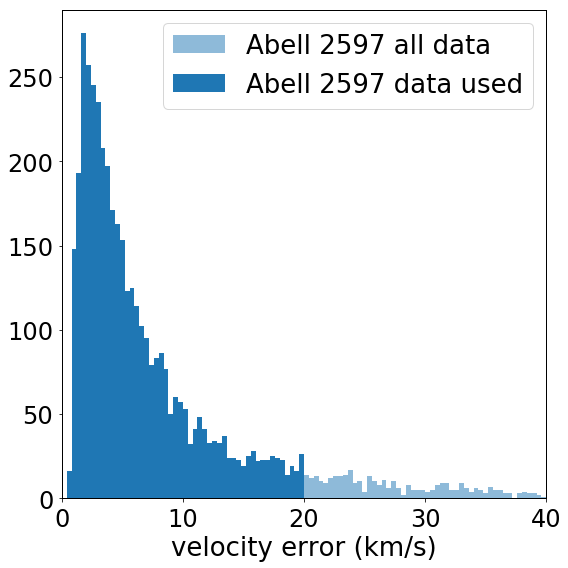

In [47]:
plt.figure(3,figsize=(8,8))
#plt.hist(error_data[error_data<max_error],bins=100,normed=True,label="all")

plt.hist(error_data[error_data>0],bins=100,label="Abell 2597 all data",range=(0,40),alpha=0.5,color="C0")
plt.hist(error_data[error_data<max_error],bins=100,label="Abell 2597 data used",range=(0,40),color="C0")
plt.xlim(0,40)
plt.xlabel("velocity error (km/s)",fontsize=26)
plt.legend()
plt.tight_layout()
#plt.savefig("Abell_velo_error_hist.png")
plt.savefig(savedir+"Abell_velo_error_hist.pdf")
plt.show()

In [48]:
goodxx=xx[good_v]
goodyy=yy[good_v]

velo_T=velo_data.T
print(velo_T[goodxx[0:10],goodyy[0:10]])
flux_T=flux_data.T

(Cy,Cx)=center  # flipped

[28.29882812 15.73828125 32.45507812 18.58007812 21.90234375 16.02539062
 43.76953125 41.66796875 38.97070312 30.30078125]


In [49]:
vel_a = np.reshape(velo_data[good_v], (velo_data[good_v].size, 1))
vel_b = np.reshape(velo_data[good_v], (1, velo_data[good_v].size))
v_diff_matrix = vel_a - vel_b

error_a = np.reshape(error_data[good_v]**2, (error_data[good_v].size, 1))
error_b = np.reshape(error_data[good_v]**2, (1, error_data[good_v].size))
#error_matrix = error_a + vel_b

error_matrix = error_a + error_b  #####check this !!!! 11/13/2020 Thanks to Jeremy

px_a = np.reshape(goodxx, (goodxx.size, 1))
px_b = np.reshape(goodxx, (1, goodxx.size))
py_a = np.reshape(goodyy, (goodyy.size, 1))
py_b = np.reshape(goodyy, (1, goodyy.size))
dist_matrix = np.sqrt((px_a - px_b)**2 + (py_a - py_b)**2)

#now compute r
acx=np.zeros((1,goodxx.size))+Cx
acy=np.zeros((1,goodxx.size))+Cy
bcx=np.zeros((goodxx.size,1))+Cx
bcy=np.zeros((goodxx.size,1))+Cy

rA_matrix=np.sqrt((px_a - acx)**2 + (py_a - acy)**2)
rB_matrix=np.sqrt((px_b - bcx)**2 + (py_b - bcy)**2)

v_diff_half = np.ndarray.flatten(np.triu(v_diff_matrix, k=0))
dist_half = np.ndarray.flatten(np.triu(dist_matrix, k=0)) # this is still a 2D matrix, with the lower half values all set to 0 
rA_half = np.ndarray.flatten(np.triu(rA_matrix, k=0)) # this is still a 2D matrix, with the lower half values all set to 0 
rB_half = np.ndarray.flatten(np.triu(rB_matrix, k=0)) # this is still a 2D matrix, with the lower half values all set to 0 
error_half=np.ndarray.flatten(np.triu(error_matrix, k=0))

good_dist = dist_half>0

np_dist=dist_half[good_dist]
np_v_diff=v_diff_half[good_dist]
rA=rA_half[good_dist]
rB=rB_half[good_dist]
np_error_2=error_half[good_dist]
# let's get the non-zero value out 


In [50]:
print(np_dist.size)

8090253


In [51]:
inner_f=(rA<=r10)&(rB<=r10)
out_f=(rA>r10)&(rB>r10)
np_dist_in=np_dist[inner_f]
np_v_diff_in=np_v_diff[inner_f]
np_error_in_2=np_error_2[inner_f]
np_dist_out_all=np_dist[out_f]
np_v_diff_out_all=np.abs(np_v_diff[out_f])
np_v_diff_2=np_v_diff**2
np_v_diff_3=np_v_diff**3
np_v_diff_4=np_v_diff**4
np_error_out_all_2=np_error_2[out_f]

#consider two points A at [Ax,Ay] and [Bx, By]
size1D=goodxx.size
for i in range(size1D):
    (Ax,Ay)=(goodxx[i],goodyy[i])
    for j in range(i,size1D):
        (Bx,By)=(goodxx[j],goodyy[j])
        distAB=np.sqrt((Ax-Bx)**2.+(Ay-By)**2.)
        dist.append(distAB)
        rA=np.sqrt((Ax-Cx)**2.+(Ay-Cy)**2.)
        rB=np.sqrt((Bx-Cx)**2.+(By-Cy)**2.)
        v_diff_AB=np.abs(velo_T[Ax,Ay]-velo_T[Bx,By])
        v_diff.append(v_diff_AB)
        if(rA<=r10)&(rB<=r10):
            dist_in.append(distAB)
            v_diff_in.append(np.abs(velo_T[Ax,Ay]-velo_T[Bx,By]))
            v_diff_in_2.append((velo_T[Ax,Ay]-velo_T[Bx,By])**2)
        if((rA>r10)&(rB>r10))&((rA<r10*2)&(rB<r10*2)):
            dist_out.append(distAB)
            v_diff_out.append(np.abs(velo_T[Ax,Ay]-velo_T[Bx,By]))
        if(rA>=r10*2)&(rB>=r10*2):
            dist_outer.append(distAB)
            v_diff_outer.append(np.abs(velo_T[Ax,Ay]-velo_T[Bx,By]))
        if(rA>r10)&(rB>r10):
            dist_out_all.append(distAB)
            v_diff_out_all.append(np.abs(velo_T[Ax,Ay]-velo_T[Bx,By]))
            v_diff_out_all_2.append((velo_T[Ax,Ay]-velo_T[Bx,By])**2)
        v_diff_2.append((velo_T[Ax,Ay]-velo_T[Bx,By])**2)
#        v_diff_3.append(np.abs(velo_T[Ax,Ay]-velo_T[Bx,By])**3)
        v_diff_weighted.append(np.abs(velo_T[Ax,Ay]*flux_T[Ax,Ay]-velo_T[Bx,By]*flux_T[Bx,By]))
#        theta.append(np.arccos(((Ax-Cx)*(Bx-Cx) + (Ay-Cy)*(By-Cy))/np.sqrt(((Ax-Cx)**2+(Ay-Cy)**2)*((Bx-Cx)**2+(By-Cy)**2))))
np_dist=np.array(dist)
np_v_diff=np.array(v_diff)

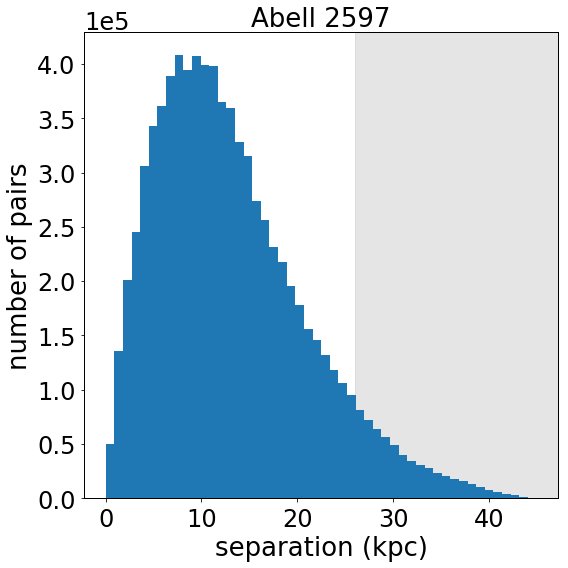

(50,) (50,)
[95567. 81703. 71835. 63454. 56324. 49016. 40140. 34809. 30630. 27622.
 23415. 20135. 17740. 15849. 13103. 10270.  7749.  5623.  4251.  2876.
  1606.   625.]


In [52]:
plt.clf()
fig, ax = plt.subplots(figsize = (8,8)) 
number,bins,_=ax.hist(np_dist*res,bins=50,range=(0,45))
ax.set_xlabel("separation (kpc)")
ax.set_ylabel("number of pairs")
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_title("Abell 2597",fontsize=26)
xlim_final=ax.get_xlim()
ylim_final=ax.get_ylim()
plt.fill_between([26,ax.get_xlim()[-1]],0,6e5,color="grey",alpha=0.2)
ax.set_xlim(xlim_final)
ax.set_ylim(ylim_final)
plt.tight_layout()
#plt.savefig("Grant_separation_hist.png")
plt.savefig(savedir+"Grant_separation_hist.pdf")
#plt.plot(np_dist,np_v_diff,marker='.', color='k', linestyle='none',markersize=0.01)
plt.show()
big=bins[:-1]>25
print(big.shape,number.shape)
print(number[big])

In [53]:
import scipy as scipy
from scipy.stats import norm
d_max=200
n_bins=100
#dist_array=np.linspace(0,d_max,num=n_bins)
dist_array=np.append([1.,  1.41, 2.,   2.23, 2.82, 3.,  3.16, 3.6,  4.,   4.12, 4.24, 4.47, 5.,   5.09],np.logspace(np.log10(5.09),np.log10(d_max),n_bins-14))
#dist_array=np.logspace(0.15,np.log10(d_max),n_bins)
v_diff_mean_zero=np.zeros(n_bins)
v_diff_mean=np.zeros(n_bins)
v_diff_mean2=np.zeros(n_bins)
v_diff_mean3=np.zeros(n_bins)
v_diff_mean3b=np.zeros(n_bins)

v_diff_mean4=np.zeros(n_bins)
v_diff_sigma=np.zeros(n_bins)
v_diff_sigma2=np.zeros(n_bins)
v_diff_sigma3=np.zeros(n_bins)

v_diff_median=np.zeros(n_bins)
error_mean=np.zeros(n_bins)
print(dist_array.shape)
for i in range(0,n_bins-1):
    this_bin=(np_dist>=dist_array[i])&(np_dist<dist_array[i+1])
    (v_diff_mean_zero[i],v_diff_sigma[i])=scipy.stats.norm.fit(np_v_diff[this_bin])
    v_diff_mean[i]=np.mean(np.abs(np_v_diff[this_bin]))
    v_diff_median[i]=np.median(np_v_diff[this_bin])
    (v_diff_mean2[i],v_diff_sigma2[i])=scipy.stats.norm.fit(np_v_diff_2[this_bin])
    (v_diff_mean3[i],v_diff_sigma3[i])=scipy.stats.norm.fit(np.abs(np_v_diff_3[this_bin]))
    #error_mean[i]=np.sqrt(np.nanmean(np_error_2[this_bin]))#old
    print(np_error_2[this_bin].size)
    error_mean[i]=np.sqrt(np.sum(np_error_2[this_bin]))/np_error_2[this_bin].size#new?
    v_diff_mean4[i]=np.mean(np_v_diff_4[this_bin])
    v_diff_mean3b[i]=np.mean(np_v_diff_3[this_bin])
    #plt.clf()
    #plt.hist(np_v_diff[this_bin],bins=50,range=(0,300))
    #plt.hist(np_v_diff_2[this_bin]/200,bins=50,alpha=0.5,range=(0,300))
    #plt.savefig("v_diff_distribution_%3.2f.png"%dist_array[i])

(100,)
7451
7318
7177
14225
6948
6918
13726
13460
6628
13183
6558
12980
19047
0
12642
12496


/Users/yli/source/yt-conda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:291: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/Users/yli/source/yt-conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yli/source/yt-conda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/Users/yli/source/yt-conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


6176
18375
12146
24033
11877
23401
23238
22865
28193
27827
11065
48975
21479
42336
31425
46382
45751
45015
49503
67993
47740
75219
46106
81851
84515
78188
85230
91780
117779
102743
96364
127537
116565
141381
139865
151300
145939
170846
158255
183147
188434
192196
208994
195108
207983
224799
221313
220109
214506
224711
217784
217809
205394
202680
197645
193386
179264
171299
168656
156663
145057
135954
128309
111655
98146
88981
78271
63869
53398
45038
37761
30729
23364
16339
8927
3902
619
39
0
0
0
0
0


In [57]:
v_diff_mean_in=np.zeros(n_bins)
v_diff_sigma_in=np.zeros(n_bins)
v_diff_mean_out=np.zeros(n_bins)
v_diff_mean_outer=np.zeros(n_bins)
v_diff_mean_out_all=np.zeros(n_bins)
v_diff_mean_out_all_2=np.zeros(n_bins)
error_mean_in=np.zeros(n_bins)
error_mean_out_all=np.zeros(n_bins)
for i in range(0,n_bins-1):
    this_bin=(np_dist_in>=dist_array[i])&(np_dist_in<dist_array[i+1])
    (v_diff_mean_zero,v_diff_sigma_in[i])=scipy.stats.norm.fit(np_v_diff_in[this_bin])
    v_diff_mean_in[i]=np.mean(np.abs(np_v_diff_in[this_bin]))
#    error_mean_in[i]=np.sqrt(np.mean(np_error_in_2[this_bin]))
    error_mean_in[i]=np.sqrt(np.sum(np_error_in_2[this_bin]))/np_error_in_2[this_bin].size 
#    that_bin=(np_dist_out>=dist_array[i])&(np_dist_out<dist_array[i+1])
#    v_diff_mean_out[i]=np.mean(np_v_diff_out[that_bin])
#    third_bin=(np_dist_outer>=dist_array[i])&(np_dist_outer<dist_array[i+1])
#    v_diff_mean_outer[i]=np.mean(np_v_diff_out[third_bin])
    out_all=(np_dist_out_all>=dist_array[i])&(np_dist_out_all<dist_array[i+1])
    v_diff_mean_out_all[i]=np.mean(np.abs(np_v_diff_out_all[out_all]))
#    error_mean_out_all[i]=np.sqrt(np.mean(np_error_out_all_2[out_all]))
#    print(np_error_out_all_2[this_bin].size)
    try:
        error_mean_out_all[i]=np.sqrt(np.sum(np_error_out_all_2[this_bin]))/np_error_out_all_2[this_bin].size 
    except:
        print("this one is empty")
        error_mean_out_all[i]=0
    #    v_diff_mean_out_all_2[i]=np.mean(np_v_diff_out_all_2[out_all])

this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty


/Users/yli/source/yt-conda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:291: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/Users/yli/source/yt-conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yli/source/yt-conda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/Users/yli/source/yt-conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one is empty
this one i

#compute radial VSF
v_diff_r=np.zeros(n_bins)
for i in range(0,n_bins-1):
    this_bin=(np_dist>=dist_array[i])&(np_dist<dist_array[i+1])&(np_theta<0.26)
    v_diff_r[i]=np.mean(np_v_diff_2[this_bin])

v_diff_r_sqrt=np.sqrt(v_diff_r)

In [58]:
print(dist_array[0:20])
print(v_diff_mean_in[20:60]/40000.)
Alma=np.load("Grant_Alma_final.npz")
print(Alma.keys())
Alma_dist_array=Alma["dist_array"]*0.2/0.8
Alma_v_diff_mean=Alma['v_diff_mean']


[1.         1.41       2.         2.23       2.82       3.
 3.16       3.6        4.         4.12       4.24       4.47
 5.         5.09       5.09       5.31464667 5.54920809 5.79412186
 6.04984488 6.31685421]
[0.00135534 0.00139015 0.00142607 0.00149258 0.00151281 0.00155829
 0.00160206 0.00162343 0.00167166 0.00170349 0.00172655 0.00177066
 0.00180689 0.00183557 0.00186292 0.00188748 0.00193395 0.00193501
 0.00198698 0.00197647 0.00199194 0.00202462 0.0020323  0.00201831
 0.00203158 0.00202485 0.00202167 0.00202295 0.00200338 0.00195898
 0.00193372 0.00188942 0.00183231 0.00180555 0.00177505 0.00170901
 0.00168681 0.00165795 0.00162507 0.00161978]
KeysView(<numpy.lib.npyio.NpzFile object at 0x1264ebd30>)


In [59]:
Irina_data = np.loadtxt('a2597_amplitude_50kpc_soft_ellip_nopsf.dat')
#Irina_data = np.loadtxt('a2597_amplitude_50kpc_soft_ellip_corpsf.dat')
Irina_k=Irina_data[:,0] #arcsecond-1  MUSE uses 21.2 kpc per arcmin
Irina_dist=(1./Irina_k)*(0.2/0.5) #convert to kpc
print(Irina_dist)
#Cs=900. #this is Perseus
Cs=722.
Irina_v=Irina_data[:,2]*Cs
Irina_v_low=Irina_data[:,3]*Cs
Irina_v_high=Irina_data[:,4]*Cs

[12.59049418 11.42857143 10.37613489  9.418413    8.55066268  7.76246846
  7.04721635  6.39795266  5.80804414  5.27287108  4.78640661  4.34546442
  3.94477318  3.58102059  3.25203252  2.95202952  2.67916946  2.43309002
  2.20872446  2.00501253  1.81983621  1.65220983  1.49981252]


In [60]:
v_diff_mean2_sqrt=np.sqrt(v_diff_mean2)

y_expect=dist_array**(1.0/3)*48
y_expect2=dist_array**(1.0/2)*26
y_expect3=dist_array**(2./3)*24


dist_array_kpc=dist_array*0.3

In [61]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
#print(dist_array[0:20])
#print(v_diff_mean3[20:60]/40000.)
#print(error_mean)
def run_helper(x,y):
    nans, x= nan_helper(y)
    z=np.copy(y)
    z[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return(z)



In [62]:
v_diff_mean_smooth=run_helper(dist_array_kpc,v_diff_mean)
error_mean_smooth=run_helper(dist_array_kpc,error_mean)
error_mean_in_smooth=run_helper(dist_array_kpc,error_mean_in)
error_mean_out_all_smooth=run_helper(dist_array_kpc,error_mean_out_all)
v_diff_mean_in_smooth=run_helper(dist_array_kpc,v_diff_mean_in)
v_diff_mean_out_all_smooth=run_helper(dist_array_kpc,v_diff_mean_out_all)

v_diff_mean_smooth=run_helper(dist_array_kpc,v_diff_mean)
lower_v=np.abs(v_diff_mean_smooth-error_mean_smooth)
upper_v=v_diff_mean_smooth+error_mean_smooth
lower_v_in=v_diff_mean_in_smooth-error_mean_in_smooth
upper_v_in=v_diff_mean_in_smooth+error_mean_in_smooth
lower_v_out=v_diff_mean_out_all_smooth-error_mean_out_all_smooth
upper_v_out=v_diff_mean_out_all_smooth+error_mean_out_all_smooth

In [63]:
def exponenial_func(x, a, b):
    return np.sqrt(a*np.exp(-b/x))


In [64]:
expo_start=4
small_dist=(dist_array_kpc<expo_start)&(dist_array_kpc>1)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponenial_func, dist_array_kpc[small_dist],v_diff_mean_smooth[small_dist], p0=(1e4, 2))
print(popt)
yy_fit = exponenial_func(dist_array_kpc, *popt)


[1.15940349e+04 3.24166343e+00]


In [65]:
PSF_low=6
print(v_diff_mean)

[ 10.55850174  13.33794587  17.07875717  18.57584812  22.34666198
  23.59548799  24.68842562  27.39502983  30.11512534  30.97877445
  31.31911763  32.99444172  36.24307418          nan  37.22200274
  38.74438414  39.94088856  41.66468357  43.17216895  44.25256995
  46.21057194  48.31247963  49.07403435  51.29988451  53.29195301
  54.86788903  55.38027882  57.97161335  59.49367314  61.50837201
  62.92105491  64.86089499  66.64529255  68.5827446   70.02793391
  71.91486308  74.10047249  75.32577177  77.66636019  78.37183478
  80.13166145  82.24957697  83.58147923  84.63983145  86.49232938
  87.90686615  89.19869796  90.66549696  91.82754753  92.17639694
  93.35675617  93.81259177  93.88354714  94.60973095  94.91258951
  94.16740954  94.31487165  94.15159361  93.93689811  94.09560982
  94.88317134  96.71925642  99.27207117 102.54425851 105.29947608
 107.63631408 108.92356075 109.68563599 110.81232658 112.59590989
 116.56462849 120.91822854 126.02913699 129.97404152 131.44517812
 132.28510

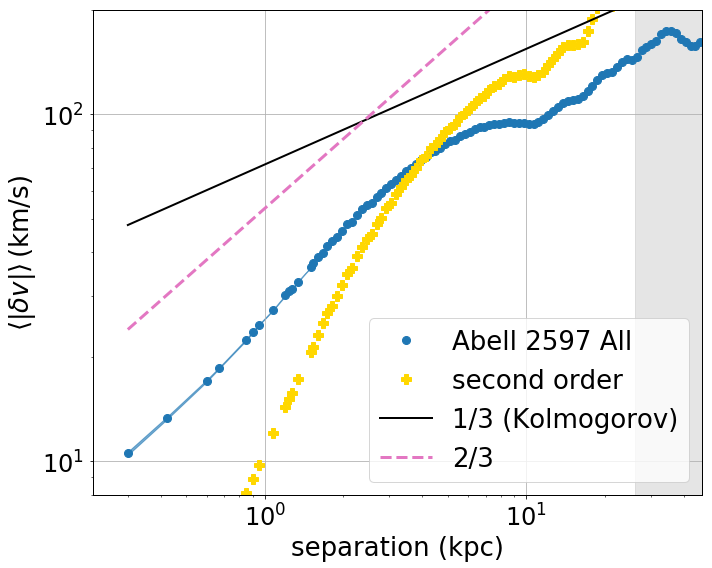

In [66]:
plt.clf()
f = plt.figure(figsize = (10,8))
#plt.plot(dist_array,v_diff_mean,marker="o")
y_try=np.sqrt(1e4*np.exp(-2/dist_array_kpc))
plt.loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=8,label = 'Abell 2597 All',color="C0")
plt.fill_between(dist_array_kpc[:-12],lower_v[:-12],upper_v[:-12],color='C0',alpha=0.6) 
#plt.fill_between(dist_array_kpc[:buhao],lower_v_in[:buhao],upper_v_in[:buhao],color="C3",alpha=0.6)
#plt.fill_between(dist_array_kpc[:-1],lower_v_out[:-1],upper_v_out[:-1],color="C2",alpha=0.6) 
plt.loglog(dist_array_kpc,v_diff_mean2/120.0,marker="P",linestyle="None",markersize=10,label = 'second order',color="gold")
#plt.loglog(dist_array_kpc,v_diff_mean3/70000.0,marker="+",linestyle="None",markersize=4,label = 'third order')
#plt.loglog(dist_array_kpc,v_diff_mean_in,marker="s",linestyle="None",markersize=3,label="r < 8 kpc",color="C3")
#plt.loglog(dist_array_kpc,v_diff_mean_out,marker="o",linestyle="None",markersize=4,label="r = 10 - 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_outer,marker="o",linestyle="None",markersize=4,label="r > 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_out_all,marker="D",linestyle="None",markersize=3,label="r > 8 kpc",color="C2")
#plt.loglog(dist_array_kpc,v_diff_mean_out_all_2/200.0,marker="o",linestyle="None",markersize=4,label="r > 10 kpc 2nd",color="purple")
#plt.plot(dist_array_kpc,v_diff_sigma*np.sqrt(2./np.pi),marker="X",linestyle="None", color="k")
#plt.plot(dist_array_kpc,v_diff_sigma_in*np.sqrt(2./np.pi),marker="X",linestyle="None", color="pink")
#plt.plot(dist_array_kpc,y_try,color="purple")
#plt.plot(dist_array_kpc[dist_array_kpc<expo_start],yy_fit[dist_array_kpc<expo_start],color="m",label="dissipation")
#plt.plot(dist_array_kpc,v_diff_mean_smooth,color="orange")

#plt.errorbar(210,13, xerr=[210,330],yerr=[13,60],label="NGC 5044",color="k")
#plt.plot([0.21,0.33],[29.9,29.9],linestyle="-",label="NGC 5044",color="k",linewidth=4)
#plt.loglog(dist_array_kpc,v_diff_mean2_sqrt,marker="*",linestyle="None",markersize=2, label="rms")
plt.loglog(dist_array_kpc,y_expect,linestyle="-",label="1/3 (Kolmogorov)",color="k")
#plt.loglog(dist_array_kpc,y_expect2,label="1/2",color="C6")
plt.loglog(dist_array_kpc,y_expect3,label="2/3",linestyle="--",color="C6",linewidth=3)
#plt.legend(("first order","second order","rms","1/3","radial"),loc="best")
#M87
#plt.legend(("first order","second order","rms","1/3","2/3","M87"),loc="best")
#plt.legend(("first order","second order","third order","r<10kpc","r>10kpc","1/3","1/2","M87"),loc="best")
#plt.plot([7,14],[185,197],linestyle="-",color="blue",linewidth=4,alpha=0.5,label="Irina 0-30 kpc")
#plt.plot([10,20],[110,140],linestyle="-",color="green",linewidth=4,alpha=0.5,label="Irina 30-60 kpc")
#plt.plot([0.052,0.104],[27,27],linestyle="-",color="k",label="Virgo",marker="|",linewidth=2)
#plt.plot(Alma_dist_array,Alma_v_diff_mean,marker="+",label="ALMA CO",linestyle="None",color="C5",markersize=6)
#plt.plot(Irina_dist,Irina_v,linestyle="--",color="C4",linewidth=3)
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.1)
#plt.plot(Irina_dist[Irina_dist<=PSF_low],Irina_v[Irina_dist<=PSF_low],linestyle=":",color="C4",linewidth=3)
#plt.fill_between(Irina_dist[Irina_dist<=PSF_low],Irina_v_low[Irina_dist<=PSF_low],Irina_v_high[Irina_dist<=PSF_low],color="C4",alpha=0.3)
#plt.plot(Irina_dist[Irina_dist>=PSF_low],Irina_v[Irina_dist>=PSF_low],linestyle="-",label="Chandra 0-50 kpc",color="C4",linewidth=3)
#plt.fill_between(Irina_dist[Irina_dist>=PSF_low],Irina_v_low[Irina_dist>=PSF_low],Irina_v_high[Irina_dist>=PSF_low],color="C4",alpha=0.2)
#plt.plot(Irina_dist,Irina_v,linestyle="--",label="Chandra 0-50 kpc",color="C4")
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.2)

#plt.loglog(dist_array_kpc,v_diff_r_sqrt,marker=".",linestyle="None",markersize=2)
#plt.loglog(dist_array_kpc,v_diff_median,marker=".",linestyle="None",markersize=2)
plt.ylim(8,200)
plt.xlim(0.22,47)
plt.xlabel("separation (kpc)")
plt.ylabel(r"$\langle|\delta v|\rangle\, \rm (km/s)$")
#plt.plot(dist_array,v_diff_median,marker="o")
#plt.plot(dist_array,v_diff_sigma,marker="X")
plt.legend(loc="lower right")#, prop={'size': 22})
plt.fill_between([26,100],0.1,300,color="grey",alpha=0.2)

plt.grid()
plt.tight_layout()
plt.savefig("Grant_Halpha_VSF_max%i_higher_order.png"%max_error)
plt.show()

In [67]:
print(v_diff_mean_in)

[ 11.56493106  15.14435865  19.99689957  22.07433251  27.08044766
  28.08992563  29.56495636  33.28354307  35.80167751  36.91279792
  38.1476567   39.72235367  43.40293578          nan  43.72961509
  45.93542438  48.20235083  49.17608682  49.92917029  52.23872271
  54.21347388  55.60615916  57.04296581  59.7031981   60.51248623
  62.3316102   64.08246979  64.937104    66.86639209  68.13955744
  69.06181577  70.82621931  72.27573472  73.42297309  74.51661188
  75.49900067  77.35804015  77.40050485  79.47906347  79.05886627
  79.67746812  80.98468687  81.29184778  80.73237333  81.26311508
  80.99381153  80.86675718  80.91797367  80.13537952  78.35922287
  77.34890996  75.57681015  73.29229925  72.22213753  71.00180199
  68.36050381  67.47257747  66.31796343  65.00295641  64.79108699
  65.76459139  68.7755395   73.85709351  81.72702025  90.52331835
  98.87646108  98.8740889   92.86681326 100.88034784          nan
          nan          nan          nan          nan          nan
          

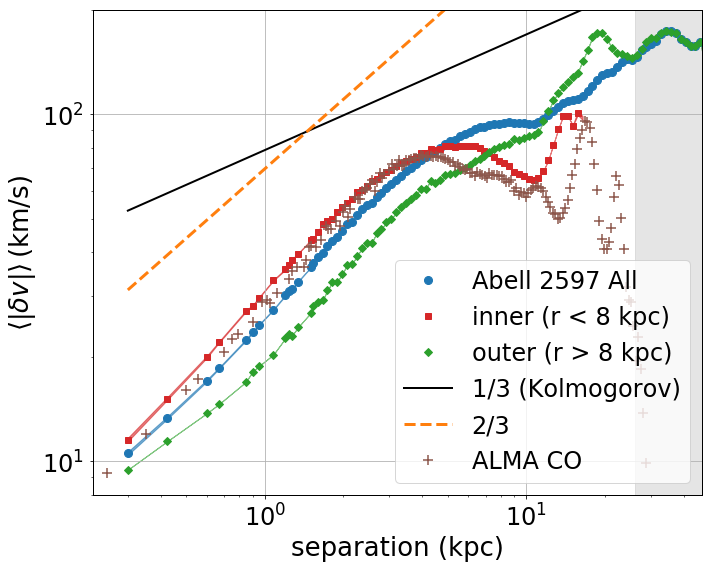

In [68]:
buhao=-30
plt.clf()
f = plt.figure(figsize = (10,8))
#plt.plot(dist_array,v_diff_mean,marker="o")
y_try=np.sqrt(1e4*np.exp(-2/dist_array_kpc))
plt.loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=8,label = 'Abell 2597 All',color="C0")
plt.fill_between(dist_array_kpc[:-12],lower_v[:-12],upper_v[:-12],color='C0',alpha=0.6) 
plt.fill_between(dist_array_kpc[:buhao],lower_v_in[:buhao],upper_v_in[:buhao],color="C3",alpha=0.6)
plt.fill_between(dist_array_kpc[:-1],lower_v_out[:-1],upper_v_out[:-1],color="C2",alpha=0.6) 
#plt.loglog(dist_array_kpc,v_diff_mean2/200.0,marker="+",linestyle="None",markersize=4,label = 'second order')
#plt.loglog(dist_array_kpc,v_diff_mean3/70000.0,marker="+",linestyle="None",markersize=4,label = 'third order')
plt.loglog(dist_array_kpc,v_diff_mean_in,marker="s",linestyle="None",markersize=6,label="inner (r < 8 kpc)",color="C3")
#plt.loglog(dist_array_kpc,v_diff_mean_out,marker="o",linestyle="None",markersize=4,label="r = 10 - 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_outer,marker="o",linestyle="None",markersize=4,label="r > 20 kpc")
plt.loglog(dist_array_kpc,v_diff_mean_out_all,marker="D",linestyle="None",markersize=6,label="outer (r > 8 kpc)",color="C2")
#plt.loglog(dist_array_kpc,v_diff_mean_out_all_2/200.0,marker="o",linestyle="None",markersize=4,label="r > 10 kpc 2nd",color="purple")
#plt.plot(dist_array_kpc,v_diff_sigma*np.sqrt(2./np.pi),marker="X",linestyle="None", color="k")
#plt.plot(dist_array_kpc,v_diff_sigma_in*np.sqrt(2./np.pi),marker="X",linestyle="None", color="pink")
#plt.plot(dist_array_kpc,y_try,color="purple")
#plt.plot(dist_array_kpc[dist_array_kpc<expo_start],yy_fit[dist_array_kpc<expo_start],color="m",label="dissipation")
#plt.plot(dist_array_kpc,v_diff_mean_smooth,color="orange")

#plt.errorbar(210,13, xerr=[210,330],yerr=[13,60],label="NGC 5044",color="k")
#plt.plot([0.21,0.33],[29.9,29.9],linestyle="-",label="NGC 5044",color="k",linewidth=4)
#plt.loglog(dist_array_kpc,v_diff_mean2_sqrt,marker="*",linestyle="None",markersize=2, label="rms")
plt.loglog(dist_array_kpc,y_expect*1.1,linestyle="-",label="1/3 (Kolmogorov)",color="k")
#plt.loglog(dist_array_kpc,y_expect2,label="1/2")
plt.loglog(dist_array_kpc,y_expect3*1.3,label="2/3",linestyle="--",color="C1",linewidth=3)
#plt.legend(("first order","second order","rms","1/3","radial"),loc="best")
#M87
#plt.legend(("first order","second order","rms","1/3","2/3","M87"),loc="best")
#plt.legend(("first order","second order","third order","r<10kpc","r>10kpc","1/3","1/2","M87"),loc="best")
#plt.plot([7,14],[185,197],linestyle="-",color="blue",linewidth=4,alpha=0.5,label="Irina 0-30 kpc")
#plt.plot([10,20],[110,140],linestyle="-",color="green",linewidth=4,alpha=0.5,label="Irina 30-60 kpc")
#plt.plot([0.052,0.104],[27,27],linestyle="-",color="k",label="Virgo",marker="|",linewidth=2)
plt.plot(Alma_dist_array,Alma_v_diff_mean,marker="+",label="ALMA CO",linestyle="None",color="C5",markersize=10,mew=1.5)
#plt.plot(Irina_dist,Irina_v,linestyle="--",color="C4",linewidth=3)
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.1)
#plt.plot(Irina_dist[Irina_dist<=PSF_low],Irina_v[Irina_dist<=PSF_low],linestyle=":",color="C4",linewidth=3)
#plt.fill_between(Irina_dist[Irina_dist<=PSF_low],Irina_v_low[Irina_dist<=PSF_low],Irina_v_high[Irina_dist<=PSF_low],color="C4",alpha=0.3)
##plt.plot(Irina_dist[Irina_dist>=PSF_low],Irina_v[Irina_dist>=PSF_low],linestyle="--",label="Chandra r<50 kpc",color="C4",linewidth=4)
##plt.fill_between(Irina_dist[Irina_dist>=PSF_low],Irina_v_low[Irina_dist>=PSF_low],Irina_v_high[Irina_dist>=PSF_low],color="C4",alpha=0.2)
#plt.plot(Irina_dist,Irina_v,linestyle="--",label="Chandra 0-50 kpc",color="C4")
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.2)

#plt.loglog(dist_array_kpc,v_diff_r_sqrt,marker=".",linestyle="None",markersize=2)
#plt.loglog(dist_array_kpc,v_diff_median,marker=".",linestyle="None",markersize=2)
plt.ylim(8,200)
plt.xlim(0.22,47)
plt.xlabel("separation (kpc)")
plt.ylabel(r"$\langle|\delta v|\rangle\, \rm (km/s)$")
#plt.plot(dist_array,v_diff_median,marker="o")
#plt.plot(dist_array,v_diff_sigma,marker="X")
plt.legend(loc="lower right", prop={'size': 24})
plt.fill_between([26,100],0.1,300,color="grey",alpha=0.2)

plt.grid()
plt.tight_layout()
#plt.savefig("Grant_Halpha_VSF_max%i.png"%max_error)
plt.savefig(savedir+"Grant_Halpha_VSF_max%i.pdf"%max_error)
plt.show()

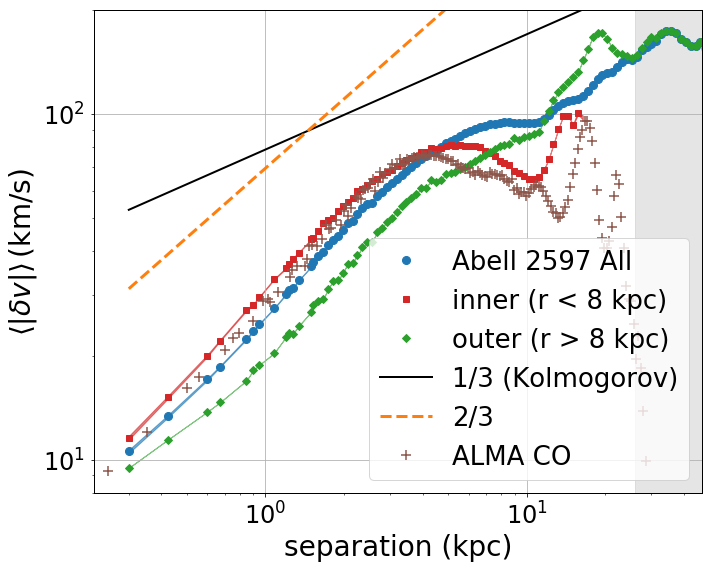

In [69]:
buhao=-30
plt.clf()
f = plt.figure(figsize = (10,8))
#plt.plot(dist_array,v_diff_mean,marker="o")
y_try=np.sqrt(1e4*np.exp(-2/dist_array_kpc))
plt.loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=8,label = 'Abell 2597 All',color="C0")
plt.fill_between(dist_array_kpc[:-12],lower_v[:-12],upper_v[:-12],color='C0',alpha=0.6) 
plt.fill_between(dist_array_kpc[:buhao],lower_v_in[:buhao],upper_v_in[:buhao],color="C3",alpha=0.6)
plt.fill_between(dist_array_kpc[:-1],lower_v_out[:-1],upper_v_out[:-1],color="C2",alpha=0.6) 
#plt.loglog(dist_array_kpc,v_diff_mean2/200.0,marker="+",linestyle="None",markersize=4,label = 'second order')
#plt.loglog(dist_array_kpc,v_diff_mean3/70000.0,marker="+",linestyle="None",markersize=4,label = 'third order')
plt.loglog(dist_array_kpc,v_diff_mean_in,marker="s",linestyle="None",markersize=6,label="inner (r < 8 kpc)",color="C3")
#plt.loglog(dist_array_kpc,v_diff_mean_out,marker="o",linestyle="None",markersize=4,label="r = 10 - 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_outer,marker="o",linestyle="None",markersize=4,label="r > 20 kpc")
plt.loglog(dist_array_kpc,v_diff_mean_out_all,marker="D",linestyle="None",markersize=6,label="outer (r > 8 kpc)",color="C2")
#plt.loglog(dist_array_kpc,v_diff_mean_out_all_2/200.0,marker="o",linestyle="None",markersize=4,label="r > 10 kpc 2nd",color="purple")
#plt.plot(dist_array_kpc,v_diff_sigma*np.sqrt(2./np.pi),marker="X",linestyle="None", color="k")
#plt.plot(dist_array_kpc,v_diff_sigma_in*np.sqrt(2./np.pi),marker="X",linestyle="None", color="pink")
#plt.plot(dist_array_kpc,y_try,color="purple")
#plt.plot(dist_array_kpc[dist_array_kpc<expo_start],yy_fit[dist_array_kpc<expo_start],color="m",label="dissipation")
#plt.plot(dist_array_kpc,v_diff_mean_smooth,color="orange")

#plt.errorbar(210,13, xerr=[210,330],yerr=[13,60],label="NGC 5044",color="k")
#plt.plot([0.21,0.33],[29.9,29.9],linestyle="-",label="NGC 5044",color="k",linewidth=4)
#plt.loglog(dist_array_kpc,v_diff_mean2_sqrt,marker="*",linestyle="None",markersize=2, label="rms")
plt.loglog(dist_array_kpc,y_expect*1.1,linestyle="-",label="1/3 (Kolmogorov)",color="k")
#plt.loglog(dist_array_kpc,y_expect2,label="1/2")
plt.loglog(dist_array_kpc,y_expect3*1.3,label="2/3",linestyle="--",color="C1",linewidth=3)
#plt.legend(("first order","second order","rms","1/3","radial"),loc="best")
#M87
#plt.legend(("first order","second order","rms","1/3","2/3","M87"),loc="best")
#plt.legend(("first order","second order","third order","r<10kpc","r>10kpc","1/3","1/2","M87"),loc="best")
#plt.plot([7,14],[185,197],linestyle="-",color="blue",linewidth=4,alpha=0.5,label="Irina 0-30 kpc")
#plt.plot([10,20],[110,140],linestyle="-",color="green",linewidth=4,alpha=0.5,label="Irina 30-60 kpc")
#plt.plot([0.052,0.104],[27,27],linestyle="-",color="k",label="Virgo",marker="|",linewidth=2)
plt.plot(Alma_dist_array,Alma_v_diff_mean,marker="+",label="ALMA CO",linestyle="None",color="C5",markersize=10,mew=1.5)
#plt.plot(Irina_dist,Irina_v,linestyle="--",color="C4",linewidth=3)
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.1)
#plt.plot(Irina_dist[Irina_dist<=PSF_low],Irina_v[Irina_dist<=PSF_low],linestyle=":",color="C4",linewidth=3)
#plt.fill_between(Irina_dist[Irina_dist<=PSF_low],Irina_v_low[Irina_dist<=PSF_low],Irina_v_high[Irina_dist<=PSF_low],color="C4",alpha=0.3)
##plt.plot(Irina_dist[Irina_dist>=PSF_low],Irina_v[Irina_dist>=PSF_low],linestyle="--",label="Chandra r<50 kpc",color="C4",linewidth=4)
##plt.fill_between(Irina_dist[Irina_dist>=PSF_low],Irina_v_low[Irina_dist>=PSF_low],Irina_v_high[Irina_dist>=PSF_low],color="C4",alpha=0.2)
#plt.plot(Irina_dist,Irina_v,linestyle="--",label="Chandra 0-50 kpc",color="C4")
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.2)

#plt.loglog(dist_array_kpc,v_diff_r_sqrt,marker=".",linestyle="None",markersize=2)
#plt.loglog(dist_array_kpc,v_diff_median,marker=".",linestyle="None",markersize=2)
plt.ylim(8,200)
plt.xlim(0.22,47)
plt.xlabel("separation (kpc)",fontsize=28)
plt.ylabel(r"$\langle|\delta v|\rangle\, \rm (km/s)$",fontsize=28)
#plt.plot(dist_array,v_diff_median,marker="o")
#plt.plot(dist_array,v_diff_sigma,marker="X")
plt.legend(loc="lower right", prop={'size': 26})
plt.fill_between([26,100],0.1,300,color="grey",alpha=0.2)

plt.grid()
plt.tight_layout()
plt.savefig("PPT/Grant_Halpha_VSF_max%i.png"%max_error)
plt.show()

/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


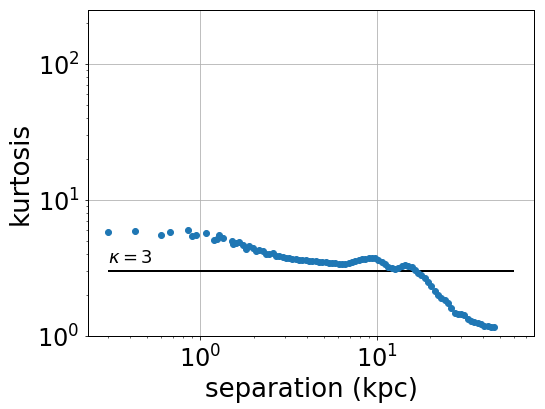

/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


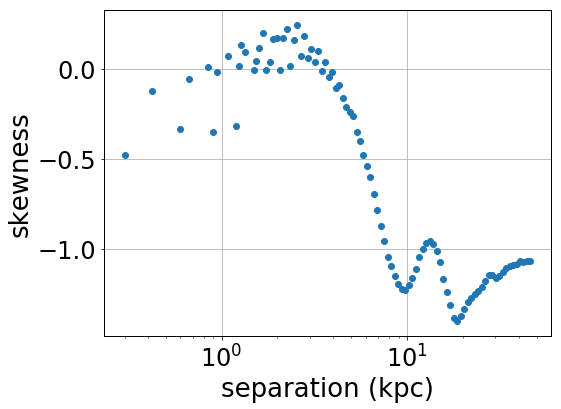

In [70]:
kurtosis=(v_diff_mean4)/(v_diff_mean2**2)
plt.clf()
plt.loglog(dist_array_kpc,kurtosis,linestyle="None",marker="o")
plt.hlines(3,dist_array_kpc[0],dist_array_kpc[-1],colors='k', linestyles='solid', label=r"$\kappa=3$")
plt.text(dist_array_kpc[0],3.5,r"$\kappa=3$",size=18)
plt.xlabel("separation (kpc)")
plt.ylabel("kurtosis")
plt.ylim(1,250)
plt.grid()
plt.show()

skewness=v_diff_mean3b/(v_diff_mean2**1.5)
plt.semilogx(dist_array_kpc,skewness,linestyle="None",marker="o")
#plt.hlines(3,dist_array_kpc[0],dist_array_kpc[-1],colors='k', linestyles='solid', label=r"$\kappa=3$")
#plt.text(dist_array_kpc[0],3.5,r"$\kappa=3$",size=18)
plt.xlabel("separation (kpc)")
plt.ylabel("skewness")
#plt.ylim(1,250)
plt.grid()
plt.savefig("Grant_skewness.png")
plt.show()

In [71]:
print(v_diff_mean3b)

[-1.48233684e+03 -7.53127114e+02 -4.35461890e+03 -9.16042039e+02
  3.58891483e+02 -1.21808694e+04 -6.20074395e+02  4.05412155e+03
 -2.27434186e+04  1.55484825e+03  1.12534208e+04  8.79333123e+03
 -2.48937440e+02             nan  5.85997108e+03  1.72181318e+04
  3.35238423e+04 -9.87992247e+02  8.08268944e+03  3.66394878e+04
  4.20694884e+04 -1.58324525e+03  4.94072654e+04  7.15720677e+04
  7.08676083e+03  6.26226409e+04  9.86027596e+04  3.27713560e+04
  8.59092739e+04  3.17157063e+04  6.08341607e+04  2.36124516e+04
  6.36268331e+04 -8.16027112e+03  2.86416704e+04 -3.43135097e+04
 -1.42758015e+04 -9.11595662e+04 -8.18659982e+04 -1.53492187e+05
 -2.14503340e+05 -2.62359889e+05 -3.02741667e+05 -4.17903746e+05
 -5.12152292e+05 -6.40953593e+05 -7.51310187e+05 -8.82602655e+05
 -1.07424393e+06 -1.24279349e+06 -1.47258232e+06 -1.66233986e+06
 -1.86581548e+06 -2.04952295e+06 -2.21178357e+06 -2.27913919e+06
 -2.39013894e+06 -2.41277765e+06 -2.31784576e+06 -2.22598377e+06
 -2.16877799e+06 -2.09275

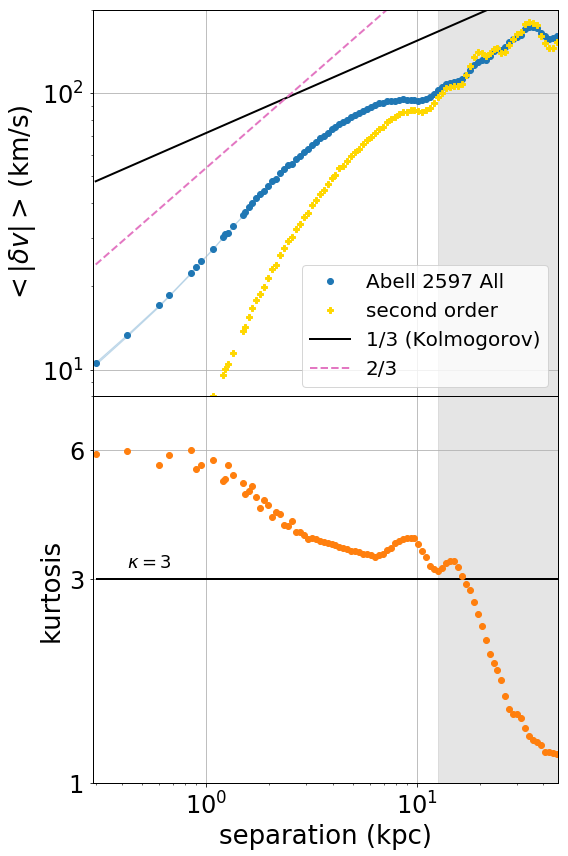

In [72]:
import matplotlib.ticker as ticker
#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                               AutoMinorLocator)
yy1=dist_array**(-1)*100
yy2=dist_array**(-2)*200


plt.clf()
f, ax = plt.subplots(2,1, sharex=True,figsize = (8,12))
ax[0].loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=6,label = 'Abell 2597 All',color="C0")
ax[0].fill_between(dist_array_kpc[:-10],lower_v[:-10],upper_v[:-10],color='C0',alpha=0.2) 
ax[0].loglog(dist_array_kpc,v_diff_mean2/180.0,marker="P",linestyle="None",markersize=6,label = 'second order',color="gold")
#plt.loglog(dist_array_kpc[0:50],y_expect2[0:50],linestyle="--",label="1/2",color="C1")
ax[0].loglog(dist_array_kpc,y_expect,linestyle="-",label="1/3 (Kolmogorov)",color="k")
ax[0].loglog(dist_array_kpc,y_expect3,label="2/3",linestyle="--",color="C6")
ax[0].set_ylim(8,200)
y_locs=np.array([1,3,6])
#y_labels=np.array([1,3,6])
y_labels=["1","3","6"]
ax[0].set_xlim(res-0.01,47)
ax[0].set_xlabel("separation (kpc)")
ax[0].set_ylabel(r"$<|\delta v|>\, \rm (km/s)$")
ax[0].legend(loc="lower right", prop={'size': 20})
ax[0].fill_between([np.max(Irina_dist),100],0.1,300,color="grey",alpha=0.2)
ax[1].fill_between([np.max(Irina_dist),100],0.1,300,color="grey",alpha=0.2)
ax[0].grid()

ax[1].loglog(dist_array_kpc,kurtosis,linestyle="None",marker="o",color="C1")
ax[1].hlines(3,dist_array_kpc[0],dist_array_kpc[-1],colors='k', linestyles='solid', label=r"$\kappa=3$")
ax[1].text(dist_array_kpc[1],3.2,r"$\kappa=3$",size=18)
ax[1].set_xlabel("separation (kpc)")
ax[1].set_ylabel("kurtosis")
ax[1].set_ylim(1,8)
ax[1].grid()
#ax[1].loglog(dist_array_kpc,yy1,linestyle="-.",color="C7")
#ax[1].loglog(dist_array_kpc,yy2,linestyle="-.",color="C7")
ax[1].yaxis.set_major_locator(ticker.FixedLocator(y_locs))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[1].yaxis.set_minor_locator(ticker.NullLocator())
plt.tight_layout()
f.subplots_adjust(hspace=0)

#ax[1].xaxis.set_major_locator(y_locs)
#ax[1].xaxis.set_major_formatter(y_labels)
plt.savefig("Grant_Halpha_VSF_max%i_higher_order_kurtosis.png"%max_error)

plt.show()

In [73]:
np.savez("Abell_final.npz",dist_array_kpc=dist_array_kpc,v_diff_mean=v_diff_mean,lower_v=lower_v,upper_v=upper_v)

In [74]:
test=np.load("Grant_v_diff_test_half.npz")
test.keys()
dist_array=test["dist_array"]
v_diff_test=test["v_diff_test"]
print(v_diff_test.shape)
#print(v_diff_test[-2,:])
#good_test=v_diff_test>0
#error1=np.amax(np.ma.masked_array(v_diff_test, mask=~good_test),axis=0)
error1=np.nanmax(v_diff_test,axis=0)
error2=np.nanmin(v_diff_test,axis=0)
error_high=run_helper(dist_array_kpc,error1)
error_low=run_helper(dist_array_kpc,error2)
error_high[error_high<=0]=1
error_low[error_low<=0]=1
#print(error_high<=0)
y_try=np.sqrt(2e4*np.exp(-1/dist_array_kpc))
plt.clf()
f = plt.figure(figsize = (10,8))
plt.loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=6,label = 'Virgo',color="C0")
plt.fill_between(dist_array_kpc[:-9],lower_v[:-9],upper_v[:-9],color="C0",alpha=0.2) 
plt.fill_between(dist_array_kpc[:-9],error_low[:-9],error_high[:-9],color="C6",hatch="X",alpha=0.2,label="Sampling Error") 
#plt.fill_between(dist_array_kpc[:-35],lower_v_in[:-35],upper_v_in[:-35],color="red",alpha=0.2)
#plt.fill_between(dist_array_kpc[:-1],lower_v_out[:-1],upper_v_out[:-1],color="green",alpha=0.2) 

#plt.loglog(dist_array_kpc,v_diff_mean2/200.0,marker="+",linestyle="None",markersize=4,label = 'second order')
#plt.loglog(dist_array_kpc,v_diff_mean3/70000.0,marker="+",linestyle="None",markersize=4,label = 'third order')
#plt.loglog(dist_array_kpc,v_diff_mean_in,marker="*",linestyle="None",markersize=2,label="r < 10 kpc",color="red")
#plt.loglog(dist_array_kpc,v_diff_mean_out,marker="o",linestyle="None",markersize=2,label="r = 10 - 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_outer,marker="o",linestyle="None",markersize=2,label="r > 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_out_all,marker="*",linestyle="None",markersize=2,label="r > 10 kpc",color="green")
#plt.loglog(dist_array_kpc,v_diff_mean_out_all_2/200.0,marker="o",linestyle="None",markersize=4,label="r > 10 kpc 2nd",color="purple")
#plt.loglog(sim_cold_dist,sim_cold_v,marker="*",linestyle="None",markersize=2,label="Sim cold",color="purple")
#plt.loglog(sim_cold_dist,sim_hot_v,marker="*",linestyle="None",markersize=2,label="Sim hot",color="pink")
#plt.errorbar(210,13, xerr=[210,330],yerr=[13,60],label="NGC 5044",color="k")
#plt.plot([0.21,0.33],[29.9,29.9],linestyle="-",label="NGC 5044",color="k",linewidth=4)
#plt.loglog(dist_array_kpc,v_diff_mean2_sqrt,marker="*",linestyle="None",markersize=2, label="rms")
plt.loglog(dist_array_kpc,y_expect,linestyle="-",label="1/3 (Kolmogorov)",color="k")
#plt.loglog(dist_array_kpc,y_expect2,label="1/2")
plt.loglog(dist_array_kpc,y_expect3,label="2/3",color="C1",linestyle="--")
#plt.loglog(dist_array_kpc,y_expect4,label="1")
#plt.plot(dist_array_kpc,y_try,color="purple")
##plt.plot(dist_array_kpc[dist_array_kpc<expo_start],yy_fit[dist_array_kpc<expo_start],color="m",label="exponential")
#plt.plot([7,14],[185,197],linestyle="-",color="blue",linewidth=4,alpha=0.5,label="Irina 0-30 kpc")
#plt.plot([10,20],[110,140],linestyle="-",color="green",linewidth=4,alpha=0.5,label="Irina 30-60 kpc")
#plt.plot([0.052,0.104],[27,27],linestyle="-",color="C5",label="Simionescu+18",marker="|",linewidth=2)
#plt.plot(Irina_dist,Irina_v,linestyle="-",label="Irina 0-40 kpc",color="purple")
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="purple",alpha=0.5)
#plt.loglog(dist_array_kpc,v_diff_mean_r,marker="o",linestyle="None",markersize=2,label="radial filaments",color="k")
#plt.loglog(dist_array_kpc,v_diff_median,marker=".",linestyle="None",markersize=2)
plt.ylim(8,200)
plt.xlim(0.22,47)
#y_locs=np.array([20,100,200])
#y_labels=np.array([20,100,200])

#plt.xlim()
plt.xlabel("separation (kpc)")
plt.ylabel(r"$<|\delta v|>\, \rm (km/s)$")
#plt.plot(dist_array,v_diff_median,marker="o")
#plt.plot(dist_array,v_diff_sigma,marker="X")
plt.legend(loc="lower right", prop={'size': 20})
#plt.grid(which='minor')
plt.grid()
#plt.yticks(y_locs, y_labels)
#plt.tight_layout()
plt.savefig("test_Grant_Halpha_VSF_max%i.png"%max_error)
plt.show()

(20, 200)


/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
/Users/yli/source/yt-conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


ValueError: Argument dimensions are incompatible

In [ ]:
print(error1.shape,dist_array_kpc.shape)

In [ ]:
cm=plt.cm.gist_rainbow
plt.clf()
for j in range(0,20):
  plt.loglog(dist_array_kpc,v_diff_test[j],marker="o",linestyle="None",markersize=4,color=cm(j/20))
#plt.fill_between(dist_array_kpc[:-9],lower_v[:-9],upper_v[:-9],color="C0",alpha=0.2) 
plt.fill_between(dist_array_kpc[:-9],error_low[:-9],error_high[:-9],color="C6",hatch="X",alpha=0.2,label="Sampling Error") 
#plt.xlim(10,200)
#plt.ylim(80,300)
plt.savefig("Grant_test_bad.png")
plt.show()


In [ ]:
buhao=-66
plt.clf()
#f = plt.figure(figsize = (16,8))
#(ax1, ax2) = plt.subplots(2, sharey=True)
f, ax = plt.subplots(1,2, sharey=True,figsize = (15,8))
#plt.plot(dist_array,v_diff_mean,marker="o")
ax[0].loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=6,label = 'Abell 2597 All',color="C0")
ax[0].fill_between(dist_array_kpc[:-12],lower_v[:-12],upper_v[:-12],color='C0',alpha=0.2) 
ax[0].loglog(dist_array_kpc,y_expect,linestyle="-",label="1/3 (Kolmogorov)",color="k")
ax[0].loglog(dist_array_kpc,y_expect3,label="2/3",linestyle="--",color="C1")
#plt.loglog(dist_array_kpc,v_diff_mean2/200.0,marker="+",linestyle="None",markersize=4,label = 'second order')
#plt.loglog(dist_array_kpc,v_diff_mean3/70000.0,marker="+",linestyle="None",markersize=4,label = 'third order')
ax[0].loglog(dist_array_kpc,v_diff_mean_in,marker="s",linestyle="None",markersize=3,label="r < 8 kpc",color="C3")
#plt.loglog(dist_array_kpc,v_diff_mean_out,marker="o",linestyle="None",markersize=4,label="r = 10 - 20 kpc")
#plt.loglog(dist_array_kpc,v_diff_mean_outer,marker="o",linestyle="None",markersize=4,label="r > 20 kpc")
ax[0].loglog(dist_array_kpc,v_diff_mean_out_all,marker="D",linestyle="None",markersize=3,label="r > 8 kpc",color="C2")
ax[0].fill_between(dist_array_kpc[:buhao],lower_v_in[:buhao],upper_v_in[:buhao],color="red",alpha=0.2)
ax[0].fill_between(dist_array_kpc[:-1],lower_v_out[:-1],upper_v_out[:-1],color="green",alpha=0.2) 
#plt.loglog(dist_array_kpc,v_diff_mean_out_all_2/200.0,marker="o",linestyle="None",markersize=4,label="r > 10 kpc 2nd",color="purple")
#plt.plot(dist_array_kpc,v_diff_sigma*np.sqrt(2./np.pi),marker="X",linestyle="None", color="k")
#plt.plot(dist_array_kpc,v_diff_sigma_in*np.sqrt(2./np.pi),marker="X",linestyle="None", color="pink")
#plt.plot(dist_array_kpc,y_try,color="purple")
#plt.plot(dist_array_kpc[dist_array_kpc<expo_start],yy_fit[dist_array_kpc<expo_start],color="m",label="dissipation")
#plt.plot(dist_array_kpc,v_diff_mean_smooth,color="orange")

#plt.errorbar(210,13, xerr=[210,330],yerr=[13,60],label="NGC 5044",color="k")
#plt.plot([0.21,0.33],[29.9,29.9],linestyle="-",label="NGC 5044",color="k",linewidth=4)
#plt.loglog(dist_array_kpc,v_diff_mean2_sqrt,marker="*",linestyle="None",markersize=2, label="rms")
ax[1].loglog(dist_array_kpc,v_diff_mean,marker="o",linestyle="None",markersize=6,label = 'Abell 2597 All',color="C0")
#ax[1].fill_between(dist_array_kpc[:-12],lower_v[:-12],upper_v[:-12],color='C0',alpha=0.2) 
ax[1].loglog(dist_array_kpc,y_expect,linestyle="-",label="1/3 (Kolmogorov)",color="k")
#plt.loglog(dist_array_kpc,y_expect2,label="1/2")
ax[1].loglog(dist_array_kpc,y_expect3,label="2/3",linestyle="--",color="C1")
#plt.legend(("first order","second order","rms","1/3","radial"),loc="best")
#M87
#plt.legend(("first order","second order","rms","1/3","2/3","M87"),loc="best")
#plt.legend(("first order","second order","third order","r<10kpc","r>10kpc","1/3","1/2","M87"),loc="best")
#plt.plot([7,14],[185,197],linestyle="-",color="blue",linewidth=4,alpha=0.5,label="Irina 0-30 kpc")
#plt.plot([10,20],[110,140],linestyle="-",color="green",linewidth=4,alpha=0.5,label="Irina 30-60 kpc")
#plt.plot([0.052,0.104],[27,27],linestyle="-",color="k",label="Virgo",marker="|",linewidth=2)
ax[1].plot(Alma_dist_array,Alma_v_diff_mean,marker="+",label="ALMA CO",linestyle="None",color="C5",markersize=7)
ax[1].plot(Irina_dist,Irina_v,linestyle="--",color="C4",linewidth=3)
ax[1].fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.1)
#plt.plot(Irina_dist[Irina_dist<=PSF_low],Irina_v[Irina_dist<=PSF_low],linestyle=":",color="C4",linewidth=3)
#plt.fill_between(Irina_dist[Irina_dist<=PSF_low],Irina_v_low[Irina_dist<=PSF_low],Irina_v_high[Irina_dist<=PSF_low],color="C4",alpha=0.3)
ax[1].plot(Irina_dist[Irina_dist>=PSF_low],Irina_v[Irina_dist>=PSF_low],linestyle="-",label="Chandra 0-50 kpc",color="C4",linewidth=3)
ax[1].fill_between(Irina_dist[Irina_dist>=PSF_low],Irina_v_low[Irina_dist>=PSF_low],Irina_v_high[Irina_dist>=PSF_low],color="C4",alpha=0.2)
#plt.plot(Irina_dist,Irina_v,linestyle="--",label="Chandra 0-50 kpc",color="C4")
#plt.fill_between(Irina_dist,Irina_v_low,Irina_v_high,color="C4",alpha=0.2)

#plt.loglog(dist_array_kpc,v_diff_r_sqrt,marker=".",linestyle="None",markersize=2)
#plt.loglog(dist_array_kpc,v_diff_median,marker=".",linestyle="None",markersize=2)
ax[0].set_ylim(8,200)
ax[0].set_xlim(0.28,47)
#ax[1].set_xlim(0.22,47)
ax[1].set_xlim(0.28,47)
ax[0].set_xlabel("separation (kpc)")
ax[1].set_xlabel("separation (kpc)")
ax[0].set_ylabel(r"$<|\delta v|>\, \rm (km/s)$")
#plt.plot(dist_array,v_diff_median,marker="o")
#plt.plot(dist_array,v_diff_sigma,marker="X")
ax[0].legend(loc="lower right", prop={'size': 20})
ax[1].legend(loc="lower right", prop={'size': 20})
ax[0].fill_between([np.max(Irina_dist),100],0.1,300,color="grey",alpha=0.2)
ax[1].fill_between([np.max(Irina_dist),100],0.1,300,color="grey",alpha=0.2)
ax[1].grid()
ax[0].grid()

plt.tight_layout()
f.subplots_adjust(wspace=0)
plt.savefig("Grant_Halpha_VSF_max%i_2in1.png"%max_error)
plt.show()

In [ ]:
k=1./dist_array_kpc
E=yy_fit**2
plt.loglog(k,E)
plt.show()

import matplotlib.gridspec as gridspec
plt.figure(0)
gs1=gridspec.GridSpec(1,1)
gs1.update(left=0.2, right=0.85,bottom=0.2,top=0.9, hspace=0.0001,wspace=0.0001)
ax=plt.subplot(gs1[0])
extent=[0,350,0,500]
#image=plt.hexbin(np.log10(np_dist),np.log10(np_v_diff),extent=extent, gridsize=70,cmap=plt.cm.Spectral_r,mincnt=1,vmin=1,vmax=100,rasterized=True)


image=plt.hexbin(np_dist,np_v_diff,extent=extent,gridsize=70,cmap=plt.cm.Spectral_r,rasterized=True)
#pylab.xlabel(r'$\log_{10}$ $\sigma_{\rm x}$')
#pylab.ylabel(r'$\log_{10}$ M$_{\rm BH}$')
pylab.xlabel("distance")
pylab.ylabel("v_diff")
cb = plt.colorbar(image)
#cb.set_label(r'Number of galaxies')
plt.show()

In [ ]:
y_expect4=dist_array**(3./3)*10
kpc=3.08e21
cs_list=100.*np.array([3,5,7])
plt.clf()
max_kpc=10
for cs in cs_list:
    v_sh=0.3*cs*1e5
    #v_sh=1.*cs*1e5*dist_array_kpc**(-0.5)
    kpc7=dist_array_kpc<max_kpc
    t_list=dist_array_kpc[kpc7]*kpc/(v_sh)  #in s
    delta_t=t_list[::-1]-t_list[0]
    v_list=v_sh/(v_sh*delta_t/(dist_array_kpc[kpc7]*kpc)+1)
    plt.loglog(dist_array_kpc[kpc7],v_list/1e5,label="cs=%i km/s"%cs)
#    plt.loglog(dist_array_kpc[kpc7],v_list/1e5,label="v_sh=%i km/s"%(v_sh/1e5))

plt.loglog(dist_array_kpc,y_expect,linestyle="-",label="1/3")
#plt.loglog(dist_array_kpc,y_expect2,linestyle="-",label="1/2")
plt.loglog(dist_array_kpc,y_expect4,linestyle="-",label="3/3")
#plt.plot([7,14],[185,197],linestyle="-",color="blue",linewidth=4,alpha=0.5,label="Irina 0-30 kpc")
plt.plot([10,20],[110,140],linestyle="-",color="green",linewidth=4,alpha=0.5,label="Irina 30-60 kpc")

plt.legend()
plt.ylim(8,300)
plt.grid()
plt.savefig("Yuan_simple_decay.png")
plt.show()


In [ ]:
v_sh=0.5*cs*1e5*dist_array_kpc**(-0.5)
plt.loglog(dist_array_kpc,v_sh/(cs*1e5))
plt.show()
print(v_sh[-10:-1])

In [ ]:
np_theta=np.array(theta)
theta_good=np_theta>0
plt.hist(np_theta[theta_good],bins=50)
plt.show()
print(np.max(np_theta))

In [ ]:
x = np.array([399.75, 989.25, 1578.75, 2168.25, 2757.75, 3347.25, 3936.75, 4526.25, 5115.75, 5705.25])
y = np.array([109,62,39,13,10,4,2,0,1,2])

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c


popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))
print(popt)
xx = np.linspace(300, 6000, 1000)
yy = exponenial_func(xx, *popt)

plt.loglog(x,y,'o', xx, yy)
plt.title('Exponential Fit')
ax = plt.gca()
ax.set_axis_bgcolor((0.898, 0.898, 0.898))
fig = plt.gcf()
plt.show()

plt.figure(0)
x1=1000./xx
y1=np.sqrt(yy)
y2=np.sqrt(1e5*np.exp(-0.5/x1)+100)
plt.loglog(x1,y2)
plt.show()


In [ ]:
n=np.array([2,10,100,500])
y=np.sqrt(10**2*n)/n
print(y)

In [ ]:
np.sqrt(500/5)